In [1]:
#Load required libraries
library(edgeR)
library(ggplot2)
library(RColorBrewer)
library(rafalib)
library(ggpubr)

Loading required package: limma

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘ggpubr’ was built under R version 4.0.2”


In [2]:
# Functions (taken from script in kraken2_clasification github)

# simple reader for a kraken report file
kraken_file_to_df <- function(fname){
    if (!file.exists(fname)){
        stop(paste('File does not exist:', fname))
    }
    df <- read.table(fname, sep='\t', quote='', header = F,
                     col.names=c('pct', 'reads.below','reads.direct','tax.level','taxid','name'))
    # trim whitespace, ensure names.
    # if no name, set it to the taxid
    for (i in 1:nrow(df)){
        if (trimws(df[i, 'name']) == ''){
            df[i, 'name'] <- df[i, 'taxid']
        }
    }
    return(df)
}

# combine a list of dataframes from reading Kraken reports and
# merge into a large matrix of read counts
# names will be taken from the names of the list
# output will have taxonmic name in rows, sample in columns
merge_kraken_df_list <- function(df.list, reads.col='reads.below'){
    # if(length(df.list) <2){
    #     stop('Must be a list longer than 1 - TODO implement this with one element')}
    if(is.null(names(df.list))){
        warning('Names of list is null, colnames of result will be empty')}

    keep.cols <- c('taxid', reads.col)
    df.list.simple <- lapply(df.list, function(x) x[, keep.cols])

    # merge on the taxid column
    merge.colname <- 'taxid'
    # Reduce to merge list of data frames into one
    merge.temp <- suppressWarnings(Reduce(function(x,y) merge(x, y, all=TRUE, by=merge.colname, sort=F), df.list.simple))
    rownames(merge.temp) <- merge.temp[,1]
    merge.mat <- as.matrix(merge.temp[,c(-1),drop=FALSE])
    colnames(merge.mat) <- names(df.list)
    merge.mat[is.na(merge.mat)] <- 0
    return(merge.mat)
}

# function to plot gene expression with associated metadata
plot_taxa <- function(gene){
    nm <- metadata
    nm$gene <- lcpm[gene, nm$Run]
    g1 <- ggplot(nm, aes(x=perturbation, y=gene)) +
        geom_boxplot() +
        theme_bw() +
        stat_compare_means() +
        ggtitle(paste('Expression of TaxID', gene)) +
        ylab('log CPM')

    g2 <- ggplot(nm, aes(x=collection_date, y=gene)) +
        geom_boxplot() +
        theme_bw() +
        stat_compare_means() +
        ggtitle(paste('Expression of TaxID', gene)) +
        ylab('log CPM')
    ggarrange(g1,g2)

}

In [3]:
#Read metadata
setwd("data")
metadata <- read.table('tables/MetadataRNASeq.csv', sep=',', quote = '', header=T)
head(metadata)

,Run,Assay.Type,AvgSpotLen,BioProject,BioSample,Experiment,Host_Age,host_body_temp,host_family_relationship,host_sex,⋯,perturbation,sample_acc,Sample.Name,SRA.Study,collection_date,env_package,samp_size,samp_unit,samp_store_dur,specific_host
,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
1,SRR5368907,RNA-Seq,100,PRJNA237795,SAMN02645017,SRX2664163,41 days,39,A,female,⋯,medicated,SRS560593,187_1.sff,SRP038757,6/5/12,MIGS/MIMS/MIMARKS.host-associated,1,grams feces,1 to 6 months,Pig_187
2,SRR5368905,RNA-Seq,99,PRJNA237795,SAMN02645019,SRX2664161,42 days,39,A,female,⋯,medicated,SRS560594,187_2.sff,SRP038757,6/6/12,MIGS/MIMS/MIMARKS.host-associated,1,grams feces,1 to 6 months,Pig_187
3,SRR5368902,RNA-Seq,100,PRJNA237795,SAMN02645023,SRX2664158,35 days,39,A,female,⋯,medicated,SRS560599,187_5.sff,SRP038757,5/30/12,MIGS/MIMS/MIMARKS.host-associated,1,grams feces,1 to 6 months,Pig_187
4,SRR5368899,RNA-Seq,99,PRJNA237795,SAMN02645024,SRX2664155,47 days,39,A,female,⋯,medicated,SRS560598,187_7.sff,SRP038757,6/11/12,MIGS/MIMS/MIMARKS.host-associated,1,grams feces,1 to 6 months,Pig_187
5,SRR5368896,RNA-Seq,100,PRJNA237795,SAMN02645029,SRX2664152,41 days,39,A,female,⋯,non-medicated,SRS560604,188_1.sff,SRP038757,6/5/12,MIGS/MIMS/MIMARKS.host-associated,1,grams feces,1 to 6 months,Pig_188
6,SRR5368894,RNA-Seq,100,PRJNA237795,SAMN02645031,SRX2664150,42 days,39,A,female,⋯,non-medicated,SRS560606,188_2.sff,SRP038757,6/6/12,MIGS/MIMS/MIMARKS.host-associated,1,grams feces,1 to 6 months,Pig_188


In [4]:
#For each sample ("Run") grab the report from Kraken and read the file
f.ext <- '.Cas12_Operons.kreport'
classification.folder <- 'tables/allCounts'
flist <- sapply(metadata$Run, function(x) file.path(classification.folder, paste(x, f.ext, sep='')))
names(flist) <- metadata$Run
if (!(all(file.exists(flist)))){
    # print which files don't exist
    message('The follwing files do not exist:')
    print(flist[!sapply(flist, file.exists)])
    stop("Some classification files do not exist!")
}
df.list <- lapply(flist, function(x) kraken_file_to_df(x))
ex.mat <- merge_kraken_df_list(df.list, reads.col = 'reads.direct')
                  

In [5]:
# Extract the taxa classification counts and norm by library size
ex.mat.classified <- ex.mat[-1, ]
ex.totals <- colSums(ex.mat)
ex.classified.totals <- colSums(ex.mat.classified)
ex.classified.frac <- ex.classified.totals/ex.totals

In [6]:
#Make some plots to show differences in covariates

metadata$ex.classified.frac <- ex.classified.frac[metadata$Run]
# metadata$ex.classified.frac <- ex.totals[metadata$Run]
g1 <- ggplot(metadata, aes(x=perturbation, y=ex.classified.frac)) +
    geom_boxplot() +
    theme_bw() +
    stat_compare_means() +
    ylab('Fraction of reads classified')
g2 <- ggplot(metadata, aes(x=perturbation, y=ex.totals)) +
    geom_boxplot() +
    theme_bw() +
    stat_compare_means() +
    ylab('Total reads')

g3 <- ggplot(metadata, aes(x=host_sex, y=ex.classified.frac)) +
    geom_boxplot() +
    theme_bw() +
    stat_compare_means()+
    ylab('Fraction of reads classified')
g4 <- ggplot(metadata, aes(x=host_sex, y=ex.totals)) +
    geom_boxplot() +
    theme_bw() +
    stat_compare_means()+
    ylab('Total reads')

g5 <- ggplot(metadata, aes(x=specific_host, y=ex.classified.frac)) +
    geom_boxplot() +
    theme_bw() +
    stat_compare_means()+
    ylab('Fraction of reads classified')
g6 <- ggplot(metadata, aes(x=specific_host, y=ex.totals)) +
    geom_boxplot() +
    theme_bw() +
    stat_compare_means()+
    ylab('Total reads')

g7 <- ggplot(metadata, aes(x=host_family_relationship, y=ex.classified.frac)) +
    geom_boxplot() +
    theme_bw() +
    stat_compare_means()+
    ylab('Fraction of reads classified')
g8 <- ggplot(metadata, aes(x=host_family_relationship, y=ex.totals)) +
    geom_boxplot() +
    theme_bw() +
    stat_compare_means()+
    ylab('Total reads')

g9 <- ggplot(metadata, aes(x=collection_date, y=ex.classified.frac)) +
    geom_boxplot() +
    theme_bw() +
    stat_compare_means()+
    ylab('Fraction of reads classified')
g10 <- ggplot(metadata, aes(x=collection_date, y=ex.totals)) +
    geom_boxplot() +
    theme_bw() +
    stat_compare_means()+
    ylab('Total reads')

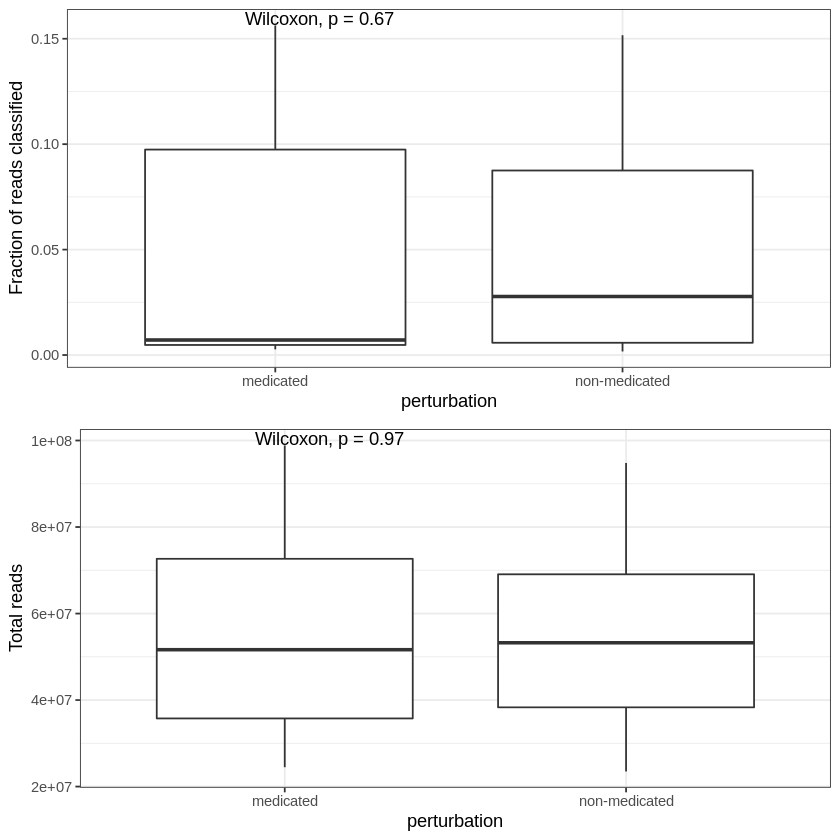

In [7]:
ggarrange(g1,g2,ncol=1,nrow=2)

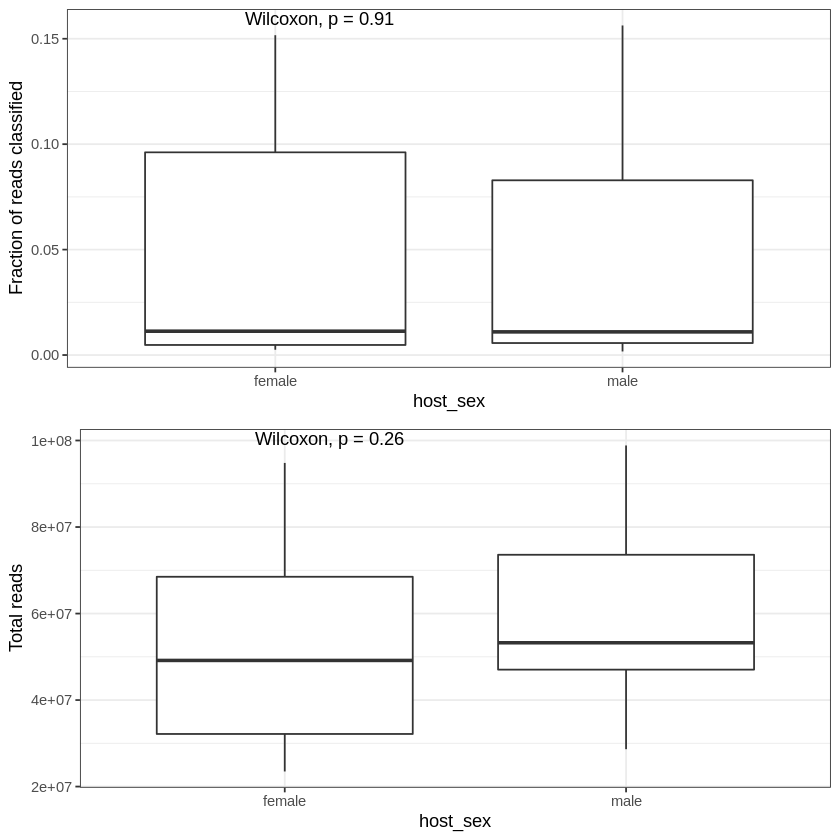

In [8]:
ggarrange(g3,g4,ncol=1,nrow=2)

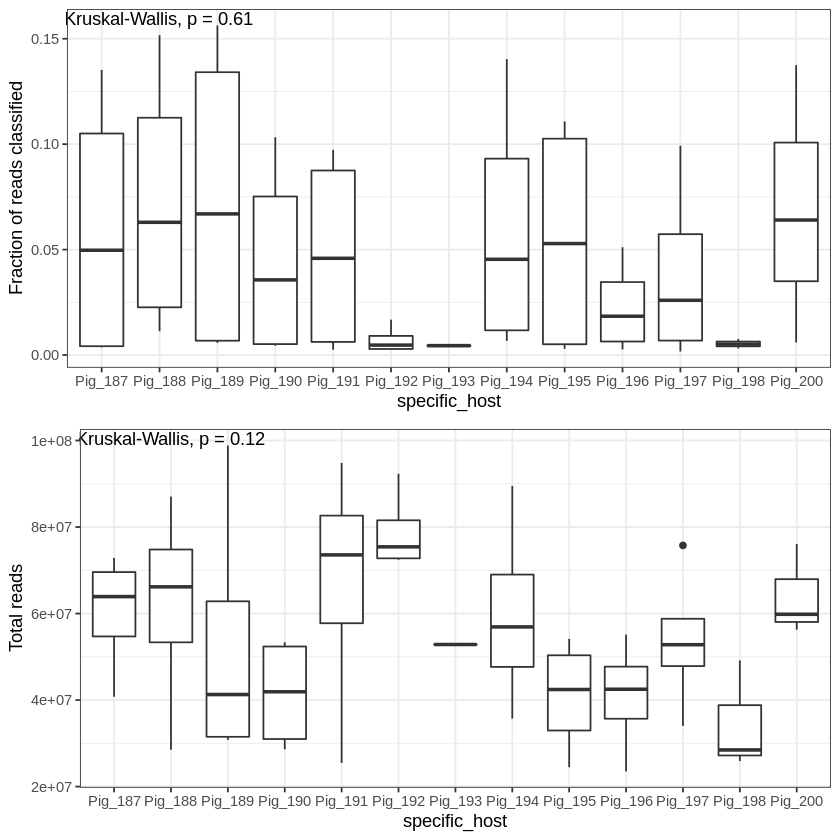

In [9]:
ggarrange(g5,g6,ncol=1,nrow=2)

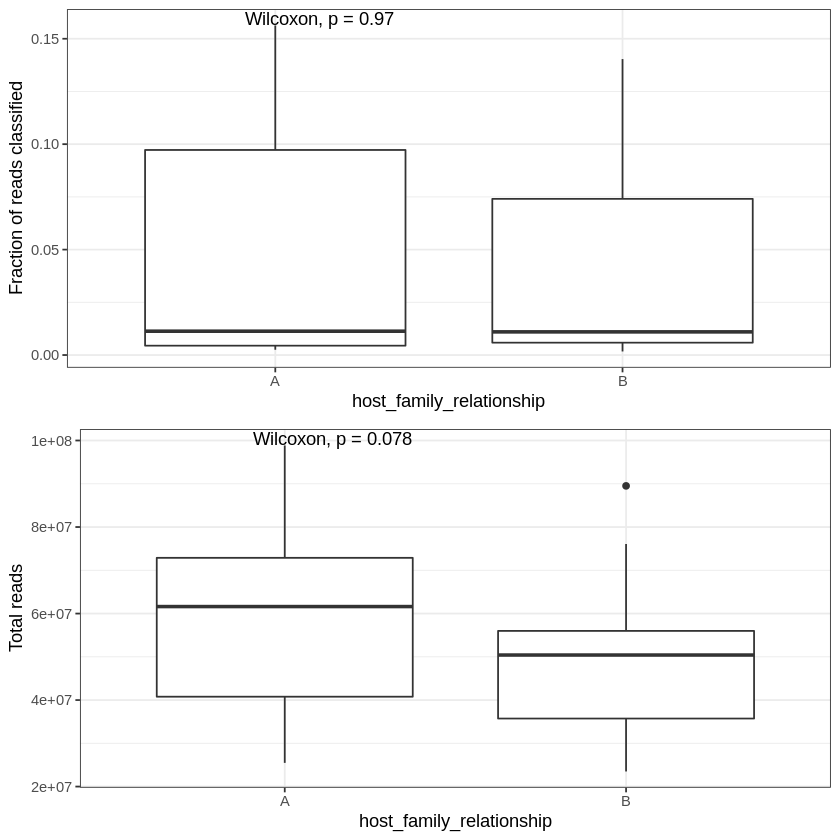

In [10]:
ggarrange(g7,g8,ncol=1,nrow=2)

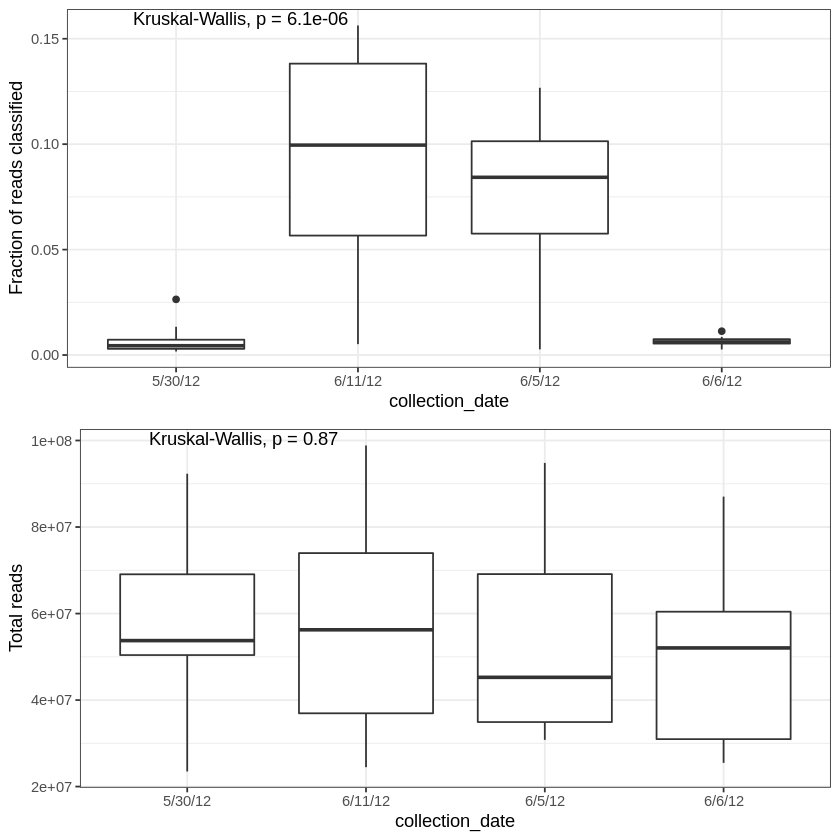

In [11]:
ggarrange(g9,g10,ncol=1,nrow=2)

In [13]:
#Save plots to files
pdf('figures/Cas12_Treatment_boxplots.pdf')
ggarrange(g1,g2,ncol=1,nrow=2)
dev.off()
pdf('figures/Cas12_HostSex_boxplots.pdf')
ggarrange(g3,g4,ncol=1,nrow=2)
dev.off()
pdf('figures/Cas12_PigID_boxplots.pdf')
ggarrange(g5,g6,ncol=1,nrow=2)
dev.off()
pdf('figures/Cas12_Parent_boxplots.pdf')
ggarrange(g7,g8,ncol=1,nrow=2)
dev.off()
pdf('figures/Cas12_sampleDate_boxplots.pdf')
ggarrange(g9,g10,ncol=1,nrow=2)
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

In [14]:
# linear model looking for differences with covariates
fit <- lm(ex.classified.frac~perturbation + host_sex + host_family_relationship + collection_date + specific_host, data=metadata)
summary(fit)


Call:
lm(formula = ex.classified.frac ~ perturbation + host_sex + host_family_relationship + 
    collection_date + specific_host, data = metadata)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.058362 -0.015084 -0.000748  0.023325  0.038926 

Coefficients: (3 not defined because of singularities)
                           Estimate Std. Error t value Pr(>|t|)    
(Intercept)                0.021530   0.016326   1.319  0.19690    
perturbationnon-medicated  0.007620   0.022223   0.343  0.73402    
host_sexmale               0.033845   0.022223   1.523  0.13791    
host_family_relationshipB -0.044530   0.022223  -2.004  0.05390 .  
collection_date6/11/12     0.086517   0.012154   7.118 5.35e-08 ***
collection_date6/5/12      0.067194   0.012518   5.368 7.48e-06 ***
collection_date6/6/12     -0.001639   0.012154  -0.135  0.89362    
specific_hostPig_188       0.005052   0.030195   0.167  0.86820    
specific_hostPig_189      -0.019408   0.030195  -0.643  0.52510    
s

In [16]:
# subset expression data to set remove low counts (Cas9)
keep.exprs <- filterByExpr(ex.mat.classified, group=metadata$perturbation,  min.count=5, min.total.count = 10)
ex.mat.classified.filt <- ex.mat.classified[keep.exprs,]
dim(ex.mat.classified)
dim(ex.mat.classified.filt)

[1] 2634   47

[1] 126  47

In [15]:
# subset expression data to set remove low counts (Cas12)
keep.exprs <- filterByExpr(ex.mat.classified, group=metadata$perturbation,  min.count=5, min.total.count = 10)
ex.mat.classified.filt <- ex.mat.classified[keep.exprs,]
dim(ex.mat.classified)
dim(ex.mat.classified.filt)

[1] 2051   47

[1] 107  47

In [16]:
# norm to counts per million
cpm <- cpm(ex.mat.classified.filt, log=FALSE)
lcpm <- cpm(ex.mat.classified.filt, log=TRUE)

In [18]:
# NMDS to look at samples by collection date
group.to.color <- brewer.pal(2, "Set1")[1:2]
names(group.to.color) <- unique(metadata$perturbation)
col.group <- group.to.color[metadata$perturbation]
date.to.color <- brewer.pal(4, "Set1")
names(date.to.color) <- unique(metadata$collection_date)
col.date <- date.to.color[metadata$collection_date]

pdf('figures/Cas12_MDS.png', height=6, width=10)
mypar(1,2)
plotMDS(lcpm, labels=1:nrow(metadata), col=col.group)
title(main="Treatment")
legend('topright', legend = names(date.to.color), fill = group.to.color)
plotMDS(lcpm, labels=1:nrow(metadata), col=col.date, xlim=c(-4,4.5), ylim=c(-2,1.7))
title(main="Collection Date")
legend('topright', legend = names(date.to.color), fill = date.to.color)
dev.off()

Warning message in brewer.pal(2, "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


png 
  2

In [20]:
## DIFFERENTIAL EXPRESSION Cas9
# design matrix for diffex
design <- model.matrix(~metadata$perturbation + metadata$collection_date)
# calculate differential ex
lfit <- lmFit(lcpm, design)
# emprical bayes
efit <- eBayes(lfit)
# number of differentially expressed genes
summary(decideTests(efit))

       (Intercept) metadata$perturbationnon-medicated
Down             0                                  0
NotSig           0                                126
Up             126                                  0
       metadata$collection_date6/11/12 metadata$collection_date6/5/12
Down                               109                            108
NotSig                              10                             11
Up                                   7                              7
       metadata$collection_date6/6/12
Down                                6
NotSig                            106
Up                                 14

In [19]:
## DIFFERENTIAL EXPRESSION Cas12
# design matrix for diffex
design <- model.matrix(~metadata$perturbation + metadata$collection_date)
# calculate differential ex
lfit <- lmFit(lcpm, design)
# emprical bayes
efit <- eBayes(lfit)
# number of differentially expressed genes
summary(decideTests(efit))

       (Intercept) metadata$perturbationnon-medicated
Down             0                                  0
NotSig           0                                107
Up             107                                  0
       metadata$collection_date6/11/12 metadata$collection_date6/5/12
Down                                92                             89
NotSig                               7                             10
Up                                   8                              8
       metadata$collection_date6/6/12
Down                                8
NotSig                             90
Up                                  9

In [21]:
diffex.perturbation <- topTreat(efit, coef='metadata$perturbationnon-medicated', number=Inf)
diffex.cd <- topTreat(efit, coef='metadata$collection_date6/11/12', number=Inf)

diffex.perturbation$taxa <- rownames(diffex.perturbation)
diffex.perturbation <- diffex.perturbation[,c('taxa', "logFC", "AveExpr", "t", "P.Value", "adj.P.Val", "B")]
diffex.cd$taxa <- rownames(diffex.cd)
diffex.cd <- diffex.cd[,c('taxa', "logFC", "AveExpr", "t", "P.Value", "adj.P.Val", "B")]

In [22]:
# plot the top number of each
n <- 4
pdf('figures/Cas9_top10DiffexPerturbation.pdf', height=4, width=6)
for (i in 1:n){
    print(plot_taxa(diffex.perturbation[i, 'taxa']))
}
dev.off()

png 
  2

In [23]:
pdf('figures/Cas9_topDiffex_sampleDate.pdf', height=4, width=6)
for (i in 1:n){
    print(plot_taxa(diffex.cd[i, 'taxa']))
}
dev.off()

# write out tables
write.table(diffex.perturbation, 'tables/Cas9_diffex_perturbation.tsv', sep='\t', quote=F, col.names = T, row.names = F)
# write.table(diffex.age, 'tables/Cas9_diffex_age.tsv', sep='\t', quote=F, col.names = T, row.names = F)

# wite expression matrices
write.table(ex.mat.classified, 'tables/Cas9_expression_matrix.tsv', sep='\t', quote=F, col.names = T, row.names = T)
write.table(ex.mat.classified.filt, 'tables/cas9_expression_matrix_filtered.tsv', sep='\t', quote=F, col.names = T, row.names = T)

png 
  2